In [31]:
import numpy as np
import pandas as pd
import torch
import os
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.decomposition import PCA
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, models
from transformers import AutoTokenizer, AutoModel

In [35]:
class KNNHateSpeechClassifier(BaseEstimator, ClassifierMixin):
    """
    KNN-based hate speech classifier using either SentenceTransformer or HateBERT.

    Args:
        threshold (float): Classification threshold.
        model_name (str): Name of Sentence-BERT model.
        n_neighbors (int): K for KNN.
        precomputed (bool): If True, skips embedding.
        use_hatebert (bool): If True, use HateBERT instead of SentenceTransformer.
    """

    def __init__(self, threshold=0.25, model_name='all-MiniLM-L6-v2',
                 n_neighbors=5, precomputed=False, use_hatebert=False):
        self.threshold = threshold
        self.model_name = model_name
        self.n_neighbors = n_neighbors
        self.precomputed = precomputed
        self.use_hatebert = use_hatebert

        self.scaler = StandardScaler()
        self.knn = KNeighborsClassifier(n_neighbors=n_neighbors)

        if use_hatebert:
            word_model = models.Transformer("GroNLP/hateBERT")
            pooling_model = models.Pooling(word_model.get_word_embedding_dimension())
            self.embedder = SentenceTransformer(modules=[word_model, pooling_model])
        else:
            self.embedder = SentenceTransformer(model_name)

    def fit(self, X, y):
        self.knn.set_params(n_neighbors=self.n_neighbors)
        if self.precomputed:
            X_scaled = self.scaler.fit_transform(X)
        else:
            X_emb = self.get_embeddings(X, scale=True)
            X_scaled = X_emb
        self.knn.fit(X_scaled, y)
        return self

    def predict_proba(self, X):
        if self.precomputed:
            X_scaled = self.scaler.transform(X)
        else:
            X_emb = self.get_embeddings(X, scale=True)
            X_scaled = X_emb
        return self.knn.predict_proba(X_scaled)

    def predict(self, X):
        probs = self.predict_proba(X)
        return (probs[:, 1] >= self.threshold).astype(int)

    def score(self, X, y):
        return np.mean(self.predict(X) == np.array(y))
    
    def get_embeddings(self, texts, scale=True, batch_size=32):
        if isinstance(texts, np.ndarray):
            texts = texts.tolist()

        embeddings = self.embedder.encode(
            texts,
            batch_size=batch_size,
            show_progress_bar=False,
            convert_to_numpy=True
        )

        return self.scaler.fit_transform(embeddings) if scale else embeddings
    

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Not Hate", "Hate"],
                    yticklabels=["Not Hate", "Hate"])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()

    def show_misclassifications(self, X, y_true, y_pred):
        X = pd.Series(X)
        y_true = pd.Series(y_true)
        y_pred = pd.Series(y_pred)
        mismatches = X[y_true != y_pred]
        print("\nFALSE POSITIVES:")
        print(mismatches[(y_true == 0) & (y_pred == 1)].head(5).to_string(index=False))
        print("\nFALSE NEGATIVES:")
        print(mismatches[(y_true == 1) & (y_pred == 0)].head(5).to_string(index=False))

    def plot_roc_curve(self, X, y_true):
        probs = self.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y_true, probs)
        auc = roc_auc_score(y_true, probs)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve - KNN Hate Speech Classifier")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [36]:
base_dir =  os.getcwd()
test_path = os.path.join(base_dir, "../data/test_data_clean.csv")
train_path = os.path.join(base_dir, "../data/train_data.csv")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_texts = train_df["text"].tolist()
train_labels = train_df["label"].tolist()
test_texts = test_df["comment"].tolist()
test_labels = test_df["isHate"].tolist()

In [37]:
model = KNNHateSpeechClassifier(use_hatebert=True)
X_train = model.get_embeddings(train_texts, scale=True)
X_test = model.get_embeddings(test_texts, scale=True)
pca = PCA(n_components=50)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

param_grid = {
    'n_neighbors': list(range(2, 7)),
    'threshold': [0.2, 0.3, 0.4, 0.5, 0.6]
}
custom_scorer = make_scorer(f1_score)

grid = HalvingGridSearchCV(
    estimator=KNNHateSpeechClassifier(precomputed=True, use_hatebert=False),
    param_grid=param_grid,
    scoring=custom_scorer,
    cv=3,
    factor=2,
    n_jobs=1,
    verbose=1
)

grid.fit(X_train_reduced, train_labels)

print("Best Threshold:", grid.best_params_['threshold'])
print("Best n_neighbors:", grid.best_params_['n_neighbors'])
best_model = grid.best_estimator_

optimal_threshold = grid.best_params_['threshold']
test_labels_bin = (np.array(test_labels) >= optimal_threshold).astype(int)
probs = best_model.predict_proba(X_test_reduced)[:, 1]
custom_preds = (probs >= optimal_threshold).astype(int)
print(classification_report(test_labels_bin, custom_preds))


n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 2571
max_resources_: 41144
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 25
n_resources: 2571
Fitting 3 folds for each of 25 candidates, totalling 75 fits
----------
iter: 1
n_candidates: 13
n_resources: 5142
Fitting 3 folds for each of 13 candidates, totalling 39 fits
----------
iter: 2
n_candidates: 7
n_resources: 10284
Fitting 3 folds for each of 7 candidates, totalling 21 fits
----------
iter: 3
n_candidates: 4
n_resources: 20568
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 4
n_candidates: 2
n_resources: 41136
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Threshold: 0.3
Best n_neighbors: 6
              precision    recall  f1-score   support

           0       0.64      0.10      0.18       482
           1       0.53      0.95      0.68       516

    accuracy                           0.54       998
   macro avg       0.5

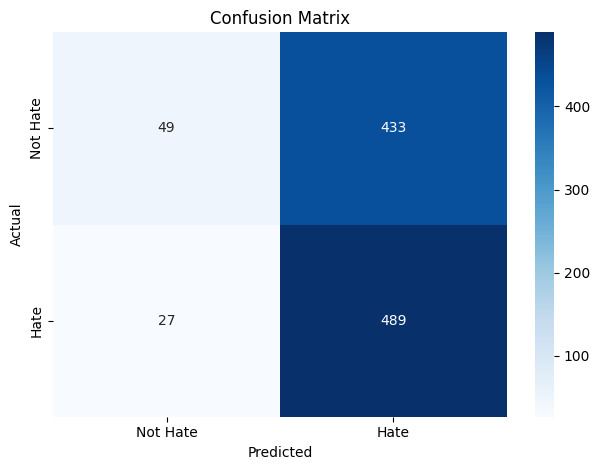


FALSE POSITIVES:
you should be allowed to be gay you should also...
You said he but still not convinced this is a m...
                Wow does ur mom know how gay u are
Women cannot create children, only men can do t...
this the type of dude you see on chat roulette ...

FALSE NEGATIVES:
Watching this kid trying to step up and walk wi...
                Islam is  the home of terriorism .
             Everyone hates you because you're gay
Autists is why presidents like trump are gettin...
     The Jew Faggot Behind The Financial Collapse.


In [42]:
best_model.plot_confusion_matrix(test_labels_bin, custom_preds)
best_model.show_misclassifications(test_texts, test_labels_bin, custom_preds)

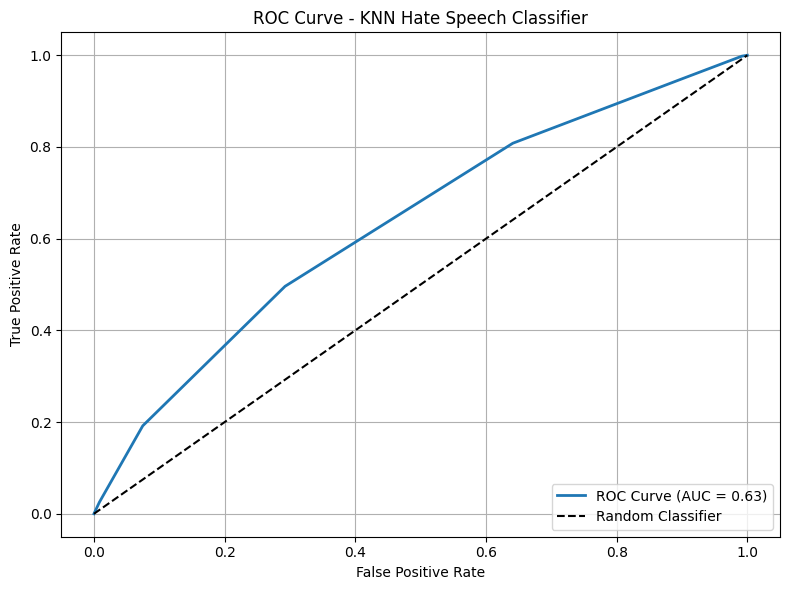

In [43]:
best_model.plot_roc_curve(X_test_reduced, test_labels_bin)

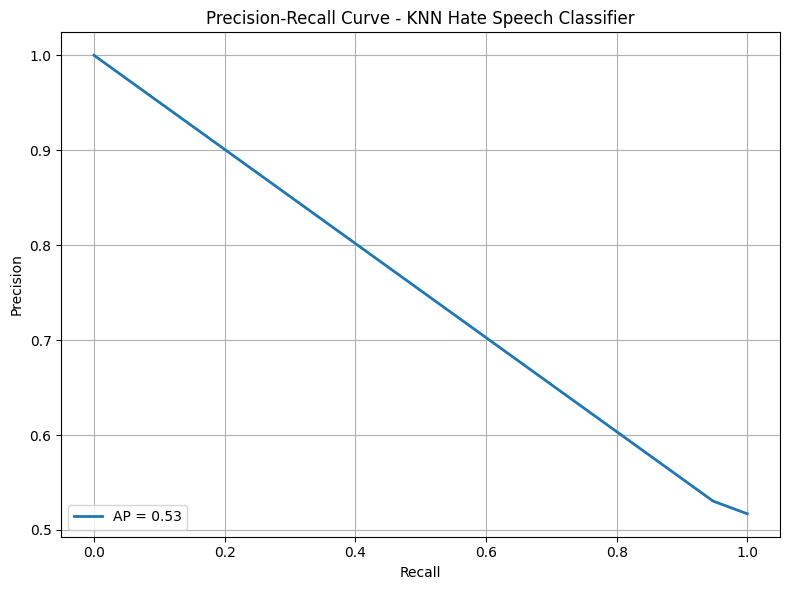

In [44]:
precision, recall, _ = precision_recall_curve(test_labels_bin, custom_preds)
avg_precision = average_precision_score(test_labels_bin, custom_preds)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - KNN Hate Speech Classifier')
plt.grid(True)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()